In [1]:
#INSTANCIATIONS AND DMA DEFNITIONS
import cv2 
from matplotlib import pyplot as plt
import numpy as np
import math
import time

from pynq import Overlay
ol = Overlay('/home/xilinx/jupyter_notebooks/Final_Version/dma_axis_ip_example.bit')

# ol?
# ol.ip_dict
# ol.gaussianBlur_0?

dma = ol.axi_dma
dma_send = ol.axi_dma.sendchannel
dma_recv = ol.axi_dma.recvchannel

hls_ip = ol.gaussianBlur_0
CONTROL_REGISTER = 0x0
hls_ip.write(CONTROL_REGISTER, 0x81)
# hls_ip.register_map

In [2]:
#MISC FUNCTIONS
#import the selected images and create a dictionary that stores the data types. 
def importImages(name):
    image_info = {}
    noisy_image = cv2.imread(name)
    height, width, channels = noisy_image.shape
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    image_info['height'] = height
    image_info['width'] = width
    image_info['channels'] = channels
    image_info['image'] = noisy_image # list of list image values
    noisy_image = cv2.cvtColor(noisy_image, cv2.COLOR_BGR2GRAY)
    image_info['bw_image'] = noisy_image #single string image
    return image_info


# Build images
def buildImage(pixel_values, dimension, original_image, bw_image):
    image_array = np.array(pixel_values).reshape((dimension, dimension))
    image_array = np.uint8(image_array)
    final_image = cv2.resize(image_array, (dimension, dimension), interpolation=cv2.INTER_NEAREST)
    return final_image


#print images: 
def printImages(original_image, final_image): 
    
    plt.figure(figsize=(12, 12))  # Set the size of the figure
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot number 1
    plt.imshow(original_image, cmap='gray')
    plt.axis('off')  # Turn off axis
    plt.title('Original Image')
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot number 2
    plt.imshow(final_image, cmap='gray')
    plt.axis('off')  # Turn off axis
    plt.title('Final Image')
    


In [3]:
#PL Side
def send2Hardware(window):
    #converting window mat into string
    
    dma_arr = []
    for i in range(len(window)):
        for j in range(len(window)):
            dma_arr.append(window[i][j])
    
    data_size = len(window) * len(window)
    input_buffer = allocate(shape=(data_size,), dtype=np.uint32)
    for i in range(data_size):
        input_buffer[i] = dma_arr[i] 
        
    output_buffer = allocate(shape=(data_size,), dtype=np.uint32)
    dma_send.transfer(input_buffer)
    dma_recv.transfer(output_buffer)
    
    sum = output_buffer[0]
    
    del input_buffer, output_buffer
    
    return sum

In [4]:
#PS Side
def gaussianBlur(image, kernel):
    
    down = 0 #determines what the kernel can compute. 
    up = 0
    right = 0 
    left = 0
    kernel_center = int((kernel - 1)/2)
    
    window = []
    for i in range(kernel):
        row = []
        
        for j in range(kernel):
            row.append(0)

        window.append(row)
    
    new_image = []
    for row in range(len(image)):
        
        new_row = []
        
        for col in range(len(image[row])):
            
            # reinitializes the value of the sum to 0
            sum = 0
            
            #center
            window[kernel_center][kernel_center] = image[row][col]

            # check down
            if((row + 1) >= len(image)):
                down = 0 
            else:
                for i in range(kernel_center, 0-1, -1):
                    if (row + i < len(image)):
                        down = i
                        break
                for i in range(down):
                    window[kernel_center + i + 1][kernel_center] = image[row + i + 1][col]
                

            # check up
            if((row - 1) < 0):
                up = 0
            else:
                for i in range(kernel_center, 0-1, -1):
                    if (row - i >= 0):
                        up = i
                        break
                for i in range(up):
                    window[kernel_center - i - 1][kernel_center] = image[row - i - 1][col]


            # check right
            if((col+1) >= len(image[row])):
                right = 0
            else:
                for i in range(kernel_center, 0-1, -1):
                    if (col + i < len(image[row])):
                        right = i
                        break
                for i in range(right):
                    window[kernel_center][kernel_center + i + 1] = image[row][col + i + 1]


            # check left
            if((col-1) < 0):
                left = 0
            else:
                for i in range(kernel_center, 0-1, -1):
                    if((col - i) >= 0):
                        left = i
                        break
                for i in range(left):
                    window[kernel_center][kernel_center - i - 1] = image[row][col - i - 1]


            #bottom right square 
            if (down > 0) and (right > 0):
                for i in range(down):
                    for j in range(right):
                        window[kernel_center + i + 1][kernel_center + j + 1] = image[row + i + 1][col + j + 1]


            #bottom left square 
            if (down > 0) and (left > 0):
                for i in range(down):
                    for j in range(left):
                        window[kernel_center + i + 1][kernel_center - j - 1] = image[row + i + 1][col - j - 1]


            #top right square 
            if (up > 0) and (right > 0):
                for i in range(up):
                    for j in range(right):
                        window[kernel_center - i - 1][kernel_center + j + 1] = image[row - i - 1][col + j + 1]


            #top left square 
            if (up > 0) and (left > 0):
                for i in range(up):
                    for j in range(left):
                        window[kernel_center - i - 1][kernel_center - j - 1] = image[row - i - 1][col - j - 1]

            new_row.append(send2Hardware(window)) 

        new_image.append(new_row) # per row
        del new_row


    return new_image

In [5]:
# grabs images, You can choose between the doggo.jpg (128x128 pixels) or noisy_barb.jpg (512x512 pixels) just comment out the required one
image_info = importImages('doggo.jpg')
# image_info = importImages('noisy_barb.jpg')

In [6]:
from pynq import allocate

# blurs the image (This part is to be converted into HLS
start = time.time()
print("Running ... ")
image_info['gaussian_blur'] = gaussianBlur(image_info['bw_image'], 5) # default of a 5x5 kernel is set
stop = time.time()
print("Finished!")

Running ... 
Finished!


In [7]:
# rebuilds the final image
image_info['final_image'] = buildImage(image_info['gaussian_blur'], image_info['height'], image_info['image'], image_info['bw_image'])

Execution time for PL: 59.16524648666382 seconds using a 5x5 gaussian kernel


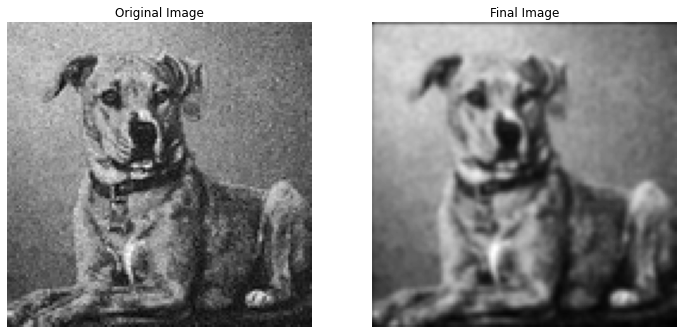

In [8]:
#output the images in matplotlib
printImages(image_info['bw_image'], image_info['final_image'])
print("Execution time for PL: " + str((stop - start)) + " seconds using a 5x5 gaussian kernel")